In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_ny_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_ny_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_ny_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [4]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

This section describes the creation of the LSTM model. Only the 'id,' 'date,' and 'price' columns are used here. The model then creates sequences of historical prices to learn temporal features that can contribute to predictive performance. The model is also hyperparameter-tuned using Optuna. Two additional variables that are tuned, besides the hyperparameters of the LSTM model itself, are 'sequence_length' and 'max_instances_per_location.'

The sequence length determines the size of the price sequences used to learn features. The max_instances_per_location parameter selects a certain number of random historical prices per unique location since using all historical prices would require too much computational power. The learned features are extracted, and the model is saved for later reuse. The max_instances_per_location is set to 100, as this has already been adjusted in the dataset, but it is kept in place just in case.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i]
            sequences.append(seq)
            labels.append(group.iloc[i]['price'])  # Correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 7, 14)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1), activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32), return_sequences=False, activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mse'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True, activation='relu')(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2, return_sequences=False, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mse'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_NY_FINAL.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_NY_FINAL.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_NY_FINAL.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


The LSTM model can be reloaded here.


In [5]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_NY_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_NY_FINAL.pkl')

# Load the model

extraction_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = extraction_model.predict(X_train)
val_features_lstm = extraction_model.predict(X_val)
test_features_lstm = extraction_model.predict(X_test)



Creating sequences: 100%|██████████| 2000/2000 [00:06<00:00, 306.29it/s]


15180/15180 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Here, the LSTM model can be reloaded to make price predictions.

In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_NY_FINAL.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_NY_FINAL.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length]['price'])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Evaluate the model on the test set
evaluation = loaded_model.evaluate(X_test, y_test, verbose=2)

# Make predictions on the test set
y_test_pred = loaded_model.predict(X_test)

# Inverse transform the predictions and true values
y_test_pred_unscaled = scaler.inverse_transform(y_test_pred)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate and display the MSE, MAE, and R-squared metrics
mse = mean_squared_error(y_test_unscaled, y_test_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_test_pred_unscaled)
r2 = r2_score(y_test_unscaled, y_test_pred_unscaled)
avg_residuals = np.mean(y_test_unscaled - y_test_pred_unscaled)

print("Evaluation - Loss, MSE, MAE:", evaluation)
print("Manual Calculation - Mean Squared Error (MSE):", mse)
print("Manual Calculation - Mean Absolute Error (MAE):", mae)
print("Manual Calculation - R-squared:", r2)
print("Manual Calculation - Average Residuals:", avg_residuals)

Creating sequences: 100%|██████████| 2000/2000 [00:05<00:00, 365.61it/s]


1250/1250 - 8s - 6ms/step - loss: 0.0230 - mean_squared_error: 0.0230
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Evaluation - Loss, MSE, MAE: [0.022982720285654068, 0.022982720285654068]
Manual Calculation - Mean Squared Error (MSE): 320.011343070489
Manual Calculation - Mean Absolute Error (MAE): 6.756929084621351
Manual Calculation - R-squared: 0.9817212836445831
Manual Calculation - Average Residuals: -5.3338952154681465


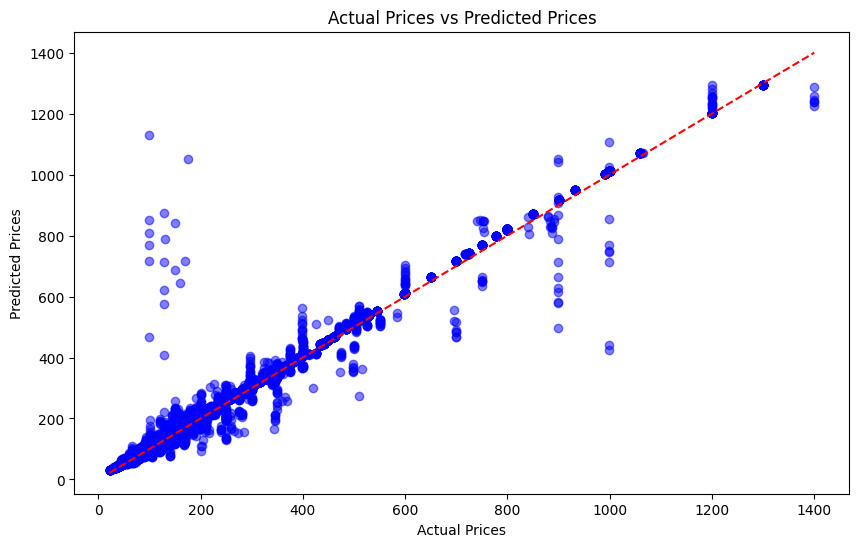

In [ ]:
# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_test_pred_unscaled, color='blue', alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs Predicted Prices')

plt.show()

In [6]:
# Unscaling the datasets
train_data_lstm_unscaled = train_data_lstm.copy()
train_data_lstm_unscaled['price'] = scaler.inverse_transform(train_data_lstm[['price']])

val_data_lstm_unscaled = val_data_lstm.copy()
val_data_lstm_unscaled['price'] = scaler.inverse_transform(val_data_lstm[['price']])

test_data_lstm_unscaled = test_data_lstm.copy()
test_data_lstm_unscaled['price'] = scaler.inverse_transform(test_data_lstm[['price']])




Code to correctly merge the LSTM features with the original data.

In [7]:
train_features_lstm = scaler.inverse_transform(train_features_lstm)
val_features_lstm = scaler.inverse_transform(val_features_lstm)
test_features_lstm = scaler.inverse_transform(test_features_lstm)

In [8]:
# Convert the extracted features and IDs into DataFrames with clean integer IDs
train_features_with_ids = pd.DataFrame(train_features_lstm)
train_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_ids]

val_features_with_ids = pd.DataFrame(val_features_lstm)
val_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_ids]

test_features_with_ids = pd.DataFrame(test_features_lstm)
test_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_ids]

# Now train_features_with_ids, val_features_with_ids, and test_features_with_ids contain the LSTM features and their associated integer IDs


In [9]:
# Extract the last occurrence of each ID's features
def extract_last_features(features, ids):
    last_features_map = {}
    for idx, id in enumerate(ids):
        last_features_map[id] = features[idx]
    unique_ids = list(last_features_map.keys())
    last_features = np.array([last_features_map[id] for id in unique_ids])
    return last_features, unique_ids

# Apply extraction of the last features
train_last_features, train_unique_ids = extract_last_features(train_features_lstm, train_ids)
val_last_features, val_unique_ids = extract_last_features(val_features_lstm, val_ids)
test_last_features, test_unique_ids = extract_last_features(test_features_lstm, test_ids)

# Convert to DataFrames
train_features_with_ids_last = pd.DataFrame(train_last_features)
train_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_unique_ids]

val_features_with_ids_last = pd.DataFrame(val_last_features)
val_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_unique_ids]

test_features_with_ids_last = pd.DataFrame(test_last_features)
test_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_unique_ids]

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [10]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [11]:

import pandas as pd

# Assume train_data_pegnn, val_data_pegnn, and test_data_pegnn are already loaded and contain the 'id' column

# Ensure IDs are consistent and merge the datasets
train_data_pegnn['id'] = train_data_pegnn['id'].astype(int)
val_data_pegnn['id'] = val_data_pegnn['id'].astype(int)
test_data_pegnn['id'] = test_data_pegnn['id'].astype(int)

train_features_with_ids_last['id'] = train_features_with_ids_last['id'].astype(int)
val_features_with_ids_last['id'] = val_features_with_ids_last['id'].astype(int)
test_features_with_ids_last['id'] = test_features_with_ids_last['id'].astype(int)

# Merge the LSTM features with the original data
train_data_pegnn = pd.merge(train_data_pegnn, train_features_with_ids_last, on='id', how='left')
val_data_pegnn = pd.merge(val_data_pegnn, val_features_with_ids_last, on='id', how='left')
test_data_pegnn = pd.merge(test_data_pegnn, test_features_with_ids_last, on='id', how='left')


In [12]:
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id', "nearby_restaurants_bars",
    "nearby_transport", "mean_price_neighbors", "neighbourhood_Astoria",
    "neighbourhood_Bedford-Stuyvesant", "neighbourhood_Chelsea",
    "neighbourhood_Clinton Hill", "neighbourhood_Crown Heights",
    "neighbourhood_East Flatbush", "neighbourhood_East Harlem",
    "neighbourhood_East Village", "neighbourhood_Financial District",
    "neighbourhood_Flatbush", "neighbourhood_Flushing",
    "neighbourhood_Fort Greene", "neighbourhood_Greenpoint",
    "neighbourhood_Harlem", "neighbourhood_Hell's Kitchen",
    "neighbourhood_Long Island City", "neighbourhood_Lower East Side",
    "neighbourhood_Midtown", "neighbourhood_Murray Hill",
    "neighbourhood_Upper East Side", "neighbourhood_Upper West Side",
    "neighbourhood_Washington Heights", "neighbourhood_West Village",
    "neighbourhood_Williamsburg", "neighbourhood_Woodside",
    "season_Autumn", "is_holiday", "is_school_holiday"
    ])





    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


# Extract and scale prices
#train_prices_pegnn = train_features_pegnn['price']
#val_prices_pegnn = val_features_pegnn['price']
#test_prices_pegnn = test_features_pegnn['price']


<ipython-input-12-b7bc8ac1d0ba>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-12-b7bc8ac1d0ba>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-12-b7bc8ac1d0ba>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,total_amenities,listing_reviewed,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,luxury_amenities_score,kitchen_amenities
0,0.0,-0.442516,-0.333333,0.0,0.0,-0.25,0.0,-0.5,0.0,0.0,...,1.157895,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.333333
1,1.0,-0.373102,0.000000,0.0,5.0,2.50,0.0,0.0,0.0,0.0,...,-0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
2,1.0,0.433839,-0.333333,0.0,0.0,0.25,-1.0,-0.5,0.0,0.0,...,-0.894737,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-0.666667
3,0.0,-0.503254,-0.333333,0.0,0.0,-0.25,0.0,0.0,1.0,0.0,...,-0.631579,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.666667
4,0.0,-0.095445,-0.333333,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.368421,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_london_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_london_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_london_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 16:45:45,413] A new study created in memory with name: no-name-bf89365c-b094-474b-91f5-4dd67541898d
Training PEGNN: 100%|██████████| 50/50 [02:28<00:00,  2.96s/it]
[I 2024-08-13 16:48:20,949] Trial 0 finished with value: 0.0462069995701313 and parameters: {'hidden_channels': 98, 'lr': 0.007978898925118657, 'k': 148, 'dropout_rate': 0.25319630708872376}. Best is trial 0 with value: 0.0462069995701313.
Training PEGNN: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s]
[I 2024-08-13 16:48:31,545] Trial 1 finished with value: 0.05747112259268761 and parameters: {'hidden_channels': 45, 'lr': 0.0009178137786859105, 'k': 13, 'dropout_rate': 0.15425168947149395}. Best is trial 0 with value: 0.0462069995701313.
Training PEGNN: 100%|██████████| 50/50 [02:10<00:00,  2.60s/it]
[I 2024-08-13 16:50:44,593] Trial 2 finished with value: 0.09487049281597137 and parameters: {'hidden_channels': 48, 'lr': 0.007186243872074143, 'k': 150, 'dropout_rate': 0.4846266675435894}. Best is trial 0 with 

Best parameters:  {'hidden_channels': 102, 'lr': 0.0012269846775383516, 'k': 78, 'dropout_rate': 0.1804998613020755}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.436152458190918, Training R-squared: -0.11572544004402108, Training MAE: 0.6844485402107239, Training MSE: 1.4361523389816284
Epoch 1, Validation Loss: 1.2443808317184448, Validation R-squared: 0.03723946804457601, Validation MAE: 0.66767817735672, Validation MSE: 1.2443808317184448


Final training:   0%|          | 1/500 [00:02<21:28,  2.58s/it]

Epoch 2, Training Loss: 1.2436072826385498, Training R-squared: 0.033860000279384406, Training MAE: 0.6649061441421509, Training MSE: 1.2436074018478394


Final training:   0%|          | 2/500 [00:04<17:53,  2.16s/it]

Epoch 2, Validation Loss: 1.1051006317138672, Validation R-squared: 0.14499876358881214, Validation MAE: 0.6590614914894104, Validation MSE: 1.1051006317138672
Epoch 3, Training Loss: 1.1083500385284424, Training R-squared: 0.1389394020710738, Training MAE: 0.6606054902076721, Training MSE: 1.1083500385284424


Final training:   1%|          | 3/500 [00:06<16:39,  2.01s/it]

Epoch 3, Validation Loss: 0.9986221194267273, Validation R-squared: 0.22737961916890737, Validation MAE: 0.6544113755226135, Validation MSE: 0.9986221194267273
Epoch 4, Training Loss: 1.0251425504684448, Training R-squared: 0.20358204286281423, Training MAE: 0.6635842323303223, Training MSE: 1.0251425504684448


Final training:   1%|          | 4/500 [00:08<16:02,  1.94s/it]

Epoch 4, Validation Loss: 0.9014479517936707, Validation R-squared: 0.3025619901686739, Validation MAE: 0.6377690434455872, Validation MSE: 0.9014479517936707
Epoch 5, Training Loss: 0.9260917901992798, Training R-squared: 0.2805330151747716, Training MAE: 0.6469510197639465, Training MSE: 0.9260918498039246


Final training:   1%|          | 5/500 [00:09<15:38,  1.90s/it]

Epoch 5, Validation Loss: 0.7998782396316528, Validation R-squared: 0.38114515353916434, Validation MAE: 0.6031224131584167, Validation MSE: 0.7998781800270081
Epoch 6, Training Loss: 0.8382555246353149, Training R-squared: 0.34877174900645935, Training MAE: 0.6170951128005981, Training MSE: 0.8382555246353149


Final training:   1%|          | 6/500 [00:11<15:23,  1.87s/it]

Epoch 6, Validation Loss: 0.6933819651603699, Validation R-squared: 0.463539823244395, Validation MAE: 0.5514642596244812, Validation MSE: 0.6933819651603699
Epoch 7, Training Loss: 0.7338485717773438, Training R-squared: 0.42988403968832145, Training MAE: 0.5646711587905884, Training MSE: 0.7338484525680542


Final training:   1%|▏         | 7/500 [00:13<15:11,  1.85s/it]

Epoch 7, Validation Loss: 0.5889626741409302, Validation R-squared: 0.5443276456486976, Validation MAE: 0.48901280760765076, Validation MSE: 0.5889626741409302
Epoch 8, Training Loss: 0.6419546008110046, Training R-squared: 0.5012750533215077, Training MAE: 0.504227876663208, Training MSE: 0.6419546008110046


Final training:   2%|▏         | 8/500 [00:15<15:00,  1.83s/it]

Epoch 8, Validation Loss: 0.49434545636177063, Validation R-squared: 0.6175316539923331, Validation MAE: 0.4248814582824707, Validation MSE: 0.49434545636177063
Epoch 9, Training Loss: 0.5449323654174805, Training R-squared: 0.576650201327001, Training MAE: 0.44110554456710815, Training MSE: 0.5449323058128357


Final training:   2%|▏         | 9/500 [00:17<14:53,  1.82s/it]

Epoch 9, Validation Loss: 0.4131246507167816, Validation R-squared: 0.6803710776254435, Validation MAE: 0.3728763461112976, Validation MSE: 0.4131246507167816
Epoch 10, Training Loss: 0.48103150725364685, Training R-squared: 0.6262938332895589, Training MAE: 0.3936689496040344, Training MSE: 0.4810314476490021


Final training:   2%|▏         | 10/500 [00:18<14:54,  1.82s/it]

Epoch 10, Validation Loss: 0.3410682678222656, Validation R-squared: 0.7361201069114448, Validation MAE: 0.33933693170547485, Validation MSE: 0.341068297624588
Epoch 11, Training Loss: 0.41631582379341125, Training R-squared: 0.6765704540250987, Training MAE: 0.3626575171947479, Training MSE: 0.41631579399108887


Final training:   2%|▏         | 11/500 [00:20<15:00,  1.84s/it]

Epoch 11, Validation Loss: 0.2721187174320221, Validation R-squared: 0.789465452883136, Validation MAE: 0.31301677227020264, Validation MSE: 0.2721187174320221
Epoch 12, Training Loss: 0.35112980008125305, Training R-squared: 0.7272125081770588, Training MAE: 0.3447718620300293, Training MSE: 0.35112980008125305


Final training:   2%|▏         | 12/500 [00:22<14:53,  1.83s/it]

Epoch 12, Validation Loss: 0.21394948661327362, Validation R-squared: 0.8344701818839573, Validation MAE: 0.2888799011707306, Validation MSE: 0.21394950151443481
Epoch 13, Training Loss: 0.3242868483066559, Training R-squared: 0.7480663937329108, Training MAE: 0.3340357542037964, Training MSE: 0.32428687810897827


Final training:   3%|▎         | 13/500 [00:24<14:50,  1.83s/it]

Epoch 13, Validation Loss: 0.1734703779220581, Validation R-squared: 0.8657883304201498, Validation MAE: 0.27185213565826416, Validation MSE: 0.1734703779220581
Epoch 14, Training Loss: 0.29276224970817566, Training R-squared: 0.7725573855376018, Training MAE: 0.32378312945365906, Training MSE: 0.29276221990585327


Final training:   3%|▎         | 14/500 [00:26<14:47,  1.83s/it]

Epoch 14, Validation Loss: 0.14034119248390198, Validation R-squared: 0.8914199314987805, Validation MAE: 0.25514939427375793, Validation MSE: 0.14034120738506317
Epoch 15, Training Loss: 0.28899717330932617, Training R-squared: 0.7754824105519316, Training MAE: 0.3179035186767578, Training MSE: 0.28899717330932617


Final training:   3%|▎         | 15/500 [00:28<14:38,  1.81s/it]

Epoch 15, Validation Loss: 0.11402326822280884, Validation R-squared: 0.911781744197555, Validation MAE: 0.2380261868238449, Validation MSE: 0.11402327567338943
Epoch 16, Training Loss: 0.26915180683135986, Training R-squared: 0.7908999795407204, Training MAE: 0.31125831604003906, Training MSE: 0.26915180683135986


Final training:   3%|▎         | 16/500 [00:29<14:38,  1.82s/it]

Epoch 16, Validation Loss: 0.09912659227848053, Validation R-squared: 0.9233071062272182, Validation MAE: 0.22467605769634247, Validation MSE: 0.09912659227848053
Epoch 17, Training Loss: 0.2606799304485321, Training R-squared: 0.7974816382279641, Training MAE: 0.30196210741996765, Training MSE: 0.2606799304485321


Final training:   3%|▎         | 17/500 [00:31<14:39,  1.82s/it]

Epoch 17, Validation Loss: 0.08446568250656128, Validation R-squared: 0.9346500503840243, Validation MAE: 0.2027178406715393, Validation MSE: 0.08446568250656128
Epoch 18, Training Loss: 0.24543792009353638, Training R-squared: 0.809322945229861, Training MAE: 0.28397566080093384, Training MSE: 0.24543790519237518


Final training:   4%|▎         | 18/500 [00:33<14:46,  1.84s/it]

Epoch 18, Validation Loss: 0.07002963125705719, Validation R-squared: 0.945819029178511, Validation MAE: 0.17804059386253357, Validation MSE: 0.07002963125705719
Epoch 19, Training Loss: 0.21789346635341644, Training R-squared: 0.8307217934026865, Training MAE: 0.2628573477268219, Training MSE: 0.21789346635341644


Final training:   4%|▍         | 19/500 [00:35<14:40,  1.83s/it]

Epoch 19, Validation Loss: 0.06257699429988861, Validation R-squared: 0.9515850335187185, Validation MAE: 0.16725458204746246, Validation MSE: 0.06257699429988861
Epoch 20, Training Loss: 0.22753331065177917, Training R-squared: 0.8232327817783356, Training MAE: 0.2574945390224457, Training MSE: 0.2275332808494568


Final training:   4%|▍         | 20/500 [00:37<14:33,  1.82s/it]

Epoch 20, Validation Loss: 0.06352803111076355, Validation R-squared: 0.9508492273033965, Validation MAE: 0.17171204090118408, Validation MSE: 0.06352803111076355
Epoch 21, Training Loss: 0.20724207162857056, Training R-squared: 0.8389967218795233, Training MAE: 0.2542952001094818, Training MSE: 0.20724208652973175


Final training:   4%|▍         | 21/500 [00:39<14:27,  1.81s/it]

Epoch 21, Validation Loss: 0.06873071193695068, Validation R-squared: 0.9468239869105128, Validation MAE: 0.1811448037624359, Validation MSE: 0.06873071193695068
Epoch 22, Training Loss: 0.20401091873645782, Training R-squared: 0.8415069554479173, Training MAE: 0.2557723820209503, Training MSE: 0.20401090383529663


Final training:   4%|▍         | 22/500 [00:40<14:24,  1.81s/it]

Epoch 22, Validation Loss: 0.07566790282726288, Validation R-squared: 0.9414567762755872, Validation MAE: 0.1914071887731552, Validation MSE: 0.07566791027784348
Epoch 23, Training Loss: 0.2025914490222931, Training R-squared: 0.8426097143807372, Training MAE: 0.25191038846969604, Training MSE: 0.20259146392345428


Final training:   5%|▍         | 23/500 [00:42<14:20,  1.80s/it]

Epoch 23, Validation Loss: 0.08181490749120712, Validation R-squared: 0.9367009150431169, Validation MAE: 0.2005787193775177, Validation MSE: 0.08181490749120712
Epoch 24, Training Loss: 0.18736985325813293, Training R-squared: 0.854435149748334, Training MAE: 0.24905216693878174, Training MSE: 0.18736986815929413


Final training:   5%|▍         | 24/500 [00:44<14:20,  1.81s/it]

Epoch 24, Validation Loss: 0.08322470635175705, Validation R-squared: 0.9356101743705327, Validation MAE: 0.20324499905109406, Validation MSE: 0.08322470635175705
Epoch 25, Training Loss: 0.19679687917232513, Training R-squared: 0.8471114401591884, Training MAE: 0.2481551170349121, Training MSE: 0.19679687917232513


Final training:   5%|▌         | 25/500 [00:46<14:29,  1.83s/it]

Epoch 25, Validation Loss: 0.07762075960636139, Validation R-squared: 0.9399458719183784, Validation MAE: 0.19614270329475403, Validation MSE: 0.07762076705694199
Epoch 26, Training Loss: 0.17693066596984863, Training R-squared: 0.8625451948310988, Training MAE: 0.24179433286190033, Training MSE: 0.17693068087100983


Final training:   5%|▌         | 26/500 [00:48<14:22,  1.82s/it]

Epoch 26, Validation Loss: 0.0684303268790245, Validation R-squared: 0.9470563857176459, Validation MAE: 0.18264682590961456, Validation MSE: 0.0684303268790245
Epoch 27, Training Loss: 0.17367960512638092, Training R-squared: 0.8650709042270739, Training MAE: 0.23564653098583221, Training MSE: 0.17367960512638092


Final training:   5%|▌         | 27/500 [00:49<14:19,  1.82s/it]

Epoch 27, Validation Loss: 0.059267736971378326, Validation R-squared: 0.9541453581233674, Validation MAE: 0.16691982746124268, Validation MSE: 0.059267736971378326
Epoch 28, Training Loss: 0.15875017642974854, Training R-squared: 0.876669350697725, Training MAE: 0.2220129817724228, Training MSE: 0.15875017642974854


Final training:   6%|▌         | 28/500 [00:51<14:12,  1.81s/it]

Epoch 28, Validation Loss: 0.05232730507850647, Validation R-squared: 0.9595150757638582, Validation MAE: 0.1532638818025589, Validation MSE: 0.05232730880379677
Epoch 29, Training Loss: 0.16818830370903015, Training R-squared: 0.8693370207083966, Training MAE: 0.21528397500514984, Training MSE: 0.16818828880786896


Final training:   6%|▌         | 29/500 [00:53<14:08,  1.80s/it]

Epoch 29, Validation Loss: 0.047735411673784256, Validation R-squared: 0.9630677608969966, Validation MAE: 0.141795814037323, Validation MSE: 0.047735411673784256
Epoch 30, Training Loss: 0.15060335397720337, Training R-squared: 0.8829985000015727, Training MAE: 0.20811742544174194, Training MSE: 0.15060335397720337


Final training:   6%|▌         | 30/500 [00:55<14:06,  1.80s/it]

Epoch 30, Validation Loss: 0.045519713312387466, Validation R-squared: 0.9647820173410896, Validation MAE: 0.1342804878950119, Validation MSE: 0.045519713312387466
Epoch 31, Training Loss: 0.16405269503593445, Training R-squared: 0.8725499014974691, Training MAE: 0.20390130579471588, Training MSE: 0.16405269503593445


Final training:   6%|▌         | 31/500 [00:57<14:09,  1.81s/it]

Epoch 31, Validation Loss: 0.0454864427447319, Validation R-squared: 0.9648077585829561, Validation MAE: 0.132181778550148, Validation MSE: 0.0454864427447319
Epoch 32, Training Loss: 0.1426265984773636, Training R-squared: 0.8891955252050555, Training MAE: 0.19572988152503967, Training MSE: 0.1426265835762024


Final training:   6%|▋         | 32/500 [00:59<14:16,  1.83s/it]

Epoch 32, Validation Loss: 0.04773055389523506, Validation R-squared: 0.963071523583659, Validation MAE: 0.13582290709018707, Validation MSE: 0.04773055389523506
Epoch 33, Training Loss: 0.13702057301998138, Training R-squared: 0.8935507606539286, Training MAE: 0.1922941505908966, Training MSE: 0.13702057301998138


Final training:   7%|▋         | 33/500 [01:00<14:11,  1.82s/it]

Epoch 33, Validation Loss: 0.05021044611930847, Validation R-squared: 0.9611528591426739, Validation MAE: 0.14030462503433228, Validation MSE: 0.05021044984459877
Epoch 34, Training Loss: 0.1358451396226883, Training R-squared: 0.8944639431807967, Training MAE: 0.18989311158657074, Training MSE: 0.1358451396226883


Final training:   7%|▋         | 34/500 [01:02<14:05,  1.81s/it]

Epoch 34, Validation Loss: 0.051120880991220474, Validation R-squared: 0.9604484738276029, Validation MAE: 0.14072741568088531, Validation MSE: 0.051120880991220474
Epoch 35, Training Loss: 0.14616051316261292, Training R-squared: 0.8864500770840938, Training MAE: 0.19524359703063965, Training MSE: 0.14616049826145172


Final training:   7%|▋         | 35/500 [01:04<14:12,  1.83s/it]

Epoch 35, Validation Loss: 0.04862483590841293, Validation R-squared: 0.9623796277240046, Validation MAE: 0.1339530497789383, Validation MSE: 0.048624832183122635
Epoch 36, Training Loss: 0.13680584728717804, Training R-squared: 0.8937175860533078, Training MAE: 0.185902401804924, Training MSE: 0.13680583238601685


Final training:   7%|▋         | 36/500 [01:06<14:08,  1.83s/it]

Epoch 36, Validation Loss: 0.045389991253614426, Validation R-squared: 0.9648823809294145, Validation MAE: 0.12512414157390594, Validation MSE: 0.045389991253614426
Epoch 37, Training Loss: 0.12692858278751373, Training R-squared: 0.9013910635901425, Training MAE: 0.17894907295703888, Training MSE: 0.12692859768867493


Final training:   7%|▋         | 37/500 [01:08<14:03,  1.82s/it]

Epoch 37, Validation Loss: 0.04301707446575165, Validation R-squared: 0.9667182769312243, Validation MAE: 0.1184956356883049, Validation MSE: 0.04301707446575165
Epoch 38, Training Loss: 0.12804044783115387, Training R-squared: 0.900527284475872, Training MAE: 0.17714804410934448, Training MSE: 0.12804046273231506


Final training:   8%|▊         | 38/500 [01:09<14:05,  1.83s/it]

Epoch 38, Validation Loss: 0.042093005031347275, Validation R-squared: 0.9674332152027153, Validation MAE: 0.11503356695175171, Validation MSE: 0.042093005031347275
Epoch 39, Training Loss: 0.1330687403678894, Training R-squared: 0.8966208925653079, Training MAE: 0.1748473346233368, Training MSE: 0.1330687254667282


Final training:   8%|▊         | 39/500 [01:11<14:09,  1.84s/it]

Epoch 39, Validation Loss: 0.042025212198495865, Validation R-squared: 0.9674856661911448, Validation MAE: 0.11324094980955124, Validation MSE: 0.042025212198495865
Epoch 40, Training Loss: 0.12665456533432007, Training R-squared: 0.9016039455180822, Training MAE: 0.1722281128168106, Training MSE: 0.12665458023548126


Final training:   8%|▊         | 40/500 [01:13<14:03,  1.83s/it]

Epoch 40, Validation Loss: 0.042744752019643784, Validation R-squared: 0.9669289702114912, Validation MAE: 0.11232374608516693, Validation MSE: 0.042744752019643784
Epoch 41, Training Loss: 0.12391006201505661, Training R-squared: 0.9037361235433671, Training MAE: 0.16962479054927826, Training MSE: 0.12391005456447601


Final training:   8%|▊         | 41/500 [01:15<13:56,  1.82s/it]

Epoch 41, Validation Loss: 0.04361322522163391, Validation R-squared: 0.9662570408985902, Validation MAE: 0.11192531138658524, Validation MSE: 0.04361322894692421
Epoch 42, Training Loss: 0.1173504963517189, Training R-squared: 0.90883214522835, Training MAE: 0.1660071760416031, Training MSE: 0.1173505038022995


Final training:   8%|▊         | 42/500 [01:17<13:50,  1.81s/it]

Epoch 42, Validation Loss: 0.04404817894101143, Validation R-squared: 0.9659205230250618, Validation MAE: 0.11152683943510056, Validation MSE: 0.04404817894101143
Epoch 43, Training Loss: 0.12281113862991333, Training R-squared: 0.904589862673024, Training MAE: 0.16173243522644043, Training MSE: 0.12281113862991333


Final training:   9%|▊         | 43/500 [01:19<13:46,  1.81s/it]

Epoch 43, Validation Loss: 0.0440729558467865, Validation R-squared: 0.9659013557971301, Validation MAE: 0.11121056973934174, Validation MSE: 0.0440729558467865
Epoch 44, Training Loss: 0.12005286663770676, Training R-squared: 0.9067327256870363, Training MAE: 0.161173015832901, Training MSE: 0.12005285918712616


Final training:   9%|▉         | 44/500 [01:20<13:40,  1.80s/it]

Epoch 44, Validation Loss: 0.04375716671347618, Validation R-squared: 0.9661456769644595, Validation MAE: 0.11065042018890381, Validation MSE: 0.04375716298818588
Epoch 45, Training Loss: 0.12188102304935455, Training R-squared: 0.9053124486703318, Training MAE: 0.16175827383995056, Training MSE: 0.12188102304935455


Final training:   9%|▉         | 45/500 [01:22<13:42,  1.81s/it]

Epoch 45, Validation Loss: 0.04190764203667641, Validation R-squared: 0.9675766284296093, Validation MAE: 0.10825170576572418, Validation MSE: 0.041907645761966705
Epoch 46, Training Loss: 0.11929739266633987, Training R-squared: 0.9073196280087031, Training MAE: 0.1574067920446396, Training MSE: 0.11929740756750107


Final training:   9%|▉         | 46/500 [01:24<13:52,  1.83s/it]

Epoch 46, Validation Loss: 0.03945084288716316, Validation R-squared: 0.9694774190305075, Validation MAE: 0.10516654700040817, Validation MSE: 0.03945084288716316
Epoch 47, Training Loss: 0.10888892412185669, Training R-squared: 0.9154058208190312, Training MAE: 0.1546505093574524, Training MSE: 0.10888891667127609


Final training:   9%|▉         | 47/500 [01:26<13:48,  1.83s/it]

Epoch 47, Validation Loss: 0.03790790215134621, Validation R-squared: 0.970671172652469, Validation MAE: 0.10287851095199585, Validation MSE: 0.037907905876636505
Epoch 48, Training Loss: 0.11591851711273193, Training R-squared: 0.9099446275516085, Training MAE: 0.15607917308807373, Training MSE: 0.11591851711273193


Final training:  10%|▉         | 48/500 [01:28<13:44,  1.83s/it]

Epoch 48, Validation Loss: 0.036623332649469376, Validation R-squared: 0.9716650286696839, Validation MAE: 0.10080842673778534, Validation MSE: 0.03662332892417908
Epoch 49, Training Loss: 0.1140761524438858, Training R-squared: 0.9113759448575205, Training MAE: 0.15320473909378052, Training MSE: 0.11407613009214401


Final training:  10%|▉         | 49/500 [01:29<13:42,  1.82s/it]

Epoch 49, Validation Loss: 0.03564726561307907, Validation R-squared: 0.9724201963858194, Validation MAE: 0.09938225895166397, Validation MSE: 0.03564726188778877
Epoch 50, Training Loss: 0.11074511706829071, Training R-squared: 0.9139637739461646, Training MAE: 0.1508626639842987, Training MSE: 0.11074510961771011


Final training:  10%|█         | 50/500 [01:31<13:38,  1.82s/it]

Epoch 50, Validation Loss: 0.035076625645160675, Validation R-squared: 0.9728616891848186, Validation MAE: 0.09842080622911453, Validation MSE: 0.035076629370450974
Epoch 51, Training Loss: 0.11523829400539398, Training R-squared: 0.9104730945228736, Training MAE: 0.15057730674743652, Training MSE: 0.11523827910423279


Final training:  10%|█         | 51/500 [01:33<13:32,  1.81s/it]

Epoch 51, Validation Loss: 0.03604692220687866, Validation R-squared: 0.9721109883843995, Validation MAE: 0.09998120367527008, Validation MSE: 0.03604692220687866
Epoch 52, Training Loss: 0.10670488327741623, Training R-squared: 0.9171025585371528, Training MAE: 0.1487007737159729, Training MSE: 0.10670489817857742


Final training:  10%|█         | 52/500 [01:35<13:31,  1.81s/it]

Epoch 52, Validation Loss: 0.037396177649497986, Validation R-squared: 0.9710670882107801, Validation MAE: 0.10195904225111008, Validation MSE: 0.03739617392420769
Epoch 53, Training Loss: 0.10785006731748581, Training R-squared: 0.9162128851437463, Training MAE: 0.14850619435310364, Training MSE: 0.10785006731748581


Final training:  11%|█         | 53/500 [01:37<13:35,  1.82s/it]

Epoch 53, Validation Loss: 0.03858485445380211, Validation R-squared: 0.9701474229068195, Validation MAE: 0.10332401096820831, Validation MSE: 0.03858485445380211
Epoch 54, Training Loss: 0.10341058671474457, Training R-squared: 0.919661861776425, Training MAE: 0.14651718735694885, Training MSE: 0.10341058671474457


Final training:  11%|█         | 54/500 [01:39<13:31,  1.82s/it]

Epoch 54, Validation Loss: 0.039383988827466965, Validation R-squared: 0.9695291465122223, Validation MAE: 0.10338135063648224, Validation MSE: 0.039383988827466965
Epoch 55, Training Loss: 0.10505548119544983, Training R-squared: 0.9183839610645035, Training MAE: 0.14731308817863464, Training MSE: 0.10505548864603043


Final training:  11%|█         | 55/500 [01:40<13:25,  1.81s/it]

Epoch 55, Validation Loss: 0.03918823227286339, Validation R-squared: 0.9696805975371978, Validation MAE: 0.10131416469812393, Validation MSE: 0.03918823227286339
Epoch 56, Training Loss: 0.10728583484888077, Training R-squared: 0.9166512370887029, Training MAE: 0.1481877714395523, Training MSE: 0.10728582739830017


Final training:  11%|█         | 56/500 [01:42<13:21,  1.81s/it]

Epoch 56, Validation Loss: 0.039049167186021805, Validation R-squared: 0.9697881924073224, Validation MAE: 0.09914517402648926, Validation MSE: 0.039049163460731506
Epoch 57, Training Loss: 0.10299857705831528, Training R-squared: 0.9199819356642472, Training MAE: 0.143376886844635, Training MSE: 0.10299857705831528


Final training:  11%|█▏        | 57/500 [01:44<13:19,  1.80s/it]

Epoch 57, Validation Loss: 0.03846833109855652, Validation R-squared: 0.9702375750363965, Validation MAE: 0.09627360850572586, Validation MSE: 0.03846833109855652
Epoch 58, Training Loss: 0.10718781501054764, Training R-squared: 0.9167273890922815, Training MAE: 0.147225022315979, Training MSE: 0.10718780755996704


Final training:  12%|█▏        | 58/500 [01:46<13:15,  1.80s/it]

Epoch 58, Validation Loss: 0.03803292289376259, Validation R-squared: 0.9705744455839515, Validation MAE: 0.09415837377309799, Validation MSE: 0.03803291916847229
Epoch 59, Training Loss: 0.09712327271699905, Training R-squared: 0.9245463805338021, Training MAE: 0.14259609580039978, Training MSE: 0.09712327271699905


Final training:  12%|█▏        | 59/500 [01:48<13:17,  1.81s/it]

Epoch 59, Validation Loss: 0.03798417001962662, Validation R-squared: 0.9706121655410617, Validation MAE: 0.09277710318565369, Validation MSE: 0.03798417001962662
Epoch 60, Training Loss: 0.10269111394882202, Training R-squared: 0.9202208041450649, Training MAE: 0.1445647031068802, Training MSE: 0.10269111394882202


Final training:  12%|█▏        | 60/500 [01:49<13:23,  1.83s/it]

Epoch 60, Validation Loss: 0.03877868503332138, Validation R-squared: 0.9699974580505374, Validation MAE: 0.09287215024232864, Validation MSE: 0.03877868503332138
Epoch 61, Training Loss: 0.10454550385475159, Training R-squared: 0.9187801543262553, Training MAE: 0.14203493297100067, Training MSE: 0.10454550385475159


Final training:  12%|█▏        | 61/500 [01:51<13:20,  1.82s/it]

Epoch 61, Validation Loss: 0.0403408519923687, Validation R-squared: 0.968788833041691, Validation MAE: 0.09410803020000458, Validation MSE: 0.0403408519923687
Epoch 62, Training Loss: 0.10134846717119217, Training R-squared: 0.9212638810542001, Training MAE: 0.14153531193733215, Training MSE: 0.10134846717119217


Final training:  12%|█▏        | 62/500 [01:53<13:15,  1.82s/it]

Epoch 62, Validation Loss: 0.04142194613814354, Validation R-squared: 0.9679524035498399, Validation MAE: 0.09514562040567398, Validation MSE: 0.04142194613814354
Epoch 63, Training Loss: 0.10175201296806335, Training R-squared: 0.9209503674348456, Training MAE: 0.14533385634422302, Training MSE: 0.10175202786922455


Final training:  13%|█▎        | 63/500 [01:55<13:08,  1.80s/it]

Epoch 63, Validation Loss: 0.04146745428442955, Validation R-squared: 0.9679171972171792, Validation MAE: 0.09511001408100128, Validation MSE: 0.04146745428442955
Epoch 64, Training Loss: 0.09965501725673676, Training R-squared: 0.922579502457989, Training MAE: 0.1406410187482834, Training MSE: 0.09965501725673676


Final training:  13%|█▎        | 64/500 [01:57<13:06,  1.80s/it]

Epoch 64, Validation Loss: 0.04008413478732109, Validation R-squared: 0.9689874522169629, Validation MAE: 0.09328591823577881, Validation MSE: 0.04008413851261139
Epoch 65, Training Loss: 0.1015135869383812, Training R-squared: 0.921135609124781, Training MAE: 0.14175772666931152, Training MSE: 0.1015135794878006


Final training:  13%|█▎        | 65/500 [01:58<13:05,  1.81s/it]

Epoch 65, Validation Loss: 0.038100600242614746, Validation R-squared: 0.9705220870121937, Validation MAE: 0.09085337817668915, Validation MSE: 0.03810059279203415
Epoch 66, Training Loss: 0.09100048989057541, Training R-squared: 0.9293030762979716, Training MAE: 0.13551436364650726, Training MSE: 0.09100048989057541


Final training:  13%|█▎        | 66/500 [02:00<13:02,  1.80s/it]

Epoch 66, Validation Loss: 0.03699813038110733, Validation R-squared: 0.9713750498145406, Validation MAE: 0.08964990824460983, Validation MSE: 0.03699813038110733
Epoch 67, Training Loss: 0.09330824762582779, Training R-squared: 0.9275102129403464, Training MAE: 0.13733036816120148, Training MSE: 0.09330824762582779


Final training:  13%|█▎        | 67/500 [02:02<13:05,  1.81s/it]

Epoch 67, Validation Loss: 0.03706419840455055, Validation R-squared: 0.9713239321647172, Validation MAE: 0.09042619913816452, Validation MSE: 0.03706420212984085
Epoch 68, Training Loss: 0.09839396923780441, Training R-squared: 0.9235591911545278, Training MAE: 0.13720180094242096, Training MSE: 0.09839396923780441


Final training:  14%|█▎        | 68/500 [02:04<13:10,  1.83s/it]

Epoch 68, Validation Loss: 0.037330154329538345, Validation R-squared: 0.971118168556328, Validation MAE: 0.09156385809183121, Validation MSE: 0.037330154329538345
Epoch 69, Training Loss: 0.09041202813386917, Training R-squared: 0.9297602442330685, Training MAE: 0.13373324275016785, Training MSE: 0.09041202813386917


Final training:  14%|█▍        | 69/500 [02:06<13:10,  1.83s/it]

Epoch 69, Validation Loss: 0.03754041716456413, Validation R-squared: 0.9709554905232609, Validation MAE: 0.09257987141609192, Validation MSE: 0.03754042088985443
Epoch 70, Training Loss: 0.096017986536026, Training R-squared: 0.9254050579839681, Training MAE: 0.13702692091464996, Training MSE: 0.096017986536026


Final training:  14%|█▍        | 70/500 [02:08<13:02,  1.82s/it]

Epoch 70, Validation Loss: 0.037509314715862274, Validation R-squared: 0.970979554682976, Validation MAE: 0.09286338835954666, Validation MSE: 0.037509314715862274
Epoch 71, Training Loss: 0.08778320997953415, Training R-squared: 0.9318025255007724, Training MAE: 0.13611021637916565, Training MSE: 0.08778322488069534


Final training:  14%|█▍        | 71/500 [02:09<12:55,  1.81s/it]

Epoch 71, Validation Loss: 0.037608180195093155, Validation R-squared: 0.9709030655189379, Validation MAE: 0.09312428534030914, Validation MSE: 0.037608176469802856
Epoch 72, Training Loss: 0.08659586310386658, Training R-squared: 0.9327249579074459, Training MAE: 0.13465657830238342, Training MSE: 0.08659586310386658


Final training:  14%|█▍        | 72/500 [02:11<12:51,  1.80s/it]

Epoch 72, Validation Loss: 0.037855278700590134, Validation R-squared: 0.970711883186094, Validation MAE: 0.09309578686952591, Validation MSE: 0.03785528615117073
Epoch 73, Training Loss: 0.09254009276628494, Training R-squared: 0.9281069802635704, Training MAE: 0.13358668982982635, Training MSE: 0.09254009276628494


Final training:  15%|█▍        | 73/500 [02:13<12:50,  1.80s/it]

Epoch 73, Validation Loss: 0.03854496404528618, Validation R-squared: 0.9701782882880579, Validation MAE: 0.09320080280303955, Validation MSE: 0.03854496031999588
Epoch 74, Training Loss: 0.09039346128702164, Training R-squared: 0.9297746669352374, Training MAE: 0.13416068255901337, Training MSE: 0.09039346128702164


Final training:  15%|█▍        | 74/500 [02:15<12:52,  1.81s/it]

Epoch 74, Validation Loss: 0.038286931812763214, Validation R-squared: 0.9703779253515519, Validation MAE: 0.09144752472639084, Validation MSE: 0.038286928087472916
Epoch 75, Training Loss: 0.0897320955991745, Training R-squared: 0.9302884717862667, Training MAE: 0.1328272521495819, Training MSE: 0.0897320955991745


Final training:  15%|█▌        | 75/500 [02:17<12:57,  1.83s/it]

Epoch 75, Validation Loss: 0.03773581236600876, Validation R-squared: 0.9708043130228415, Validation MAE: 0.08917368948459625, Validation MSE: 0.03773581609129906
Epoch 76, Training Loss: 0.09425858408212662, Training R-squared: 0.926771907720167, Training MAE: 0.13444145023822784, Training MSE: 0.09425858408212662


Final training:  15%|█▌        | 76/500 [02:18<12:51,  1.82s/it]

Epoch 76, Validation Loss: 0.037543945014476776, Validation R-squared: 0.9709527624658821, Validation MAE: 0.08765441924333572, Validation MSE: 0.03754394128918648
Epoch 77, Training Loss: 0.09212858229875565, Training R-squared: 0.9284266759798034, Training MAE: 0.13364821672439575, Training MSE: 0.09212858229875565


Final training:  15%|█▌        | 77/500 [02:20<12:46,  1.81s/it]

Epoch 77, Validation Loss: 0.03817173093557358, Validation R-squared: 0.9704670529996827, Validation MAE: 0.08743109554052353, Validation MSE: 0.03817173093557358
Epoch 78, Training Loss: 0.08952521532773972, Training R-squared: 0.9304491970282753, Training MAE: 0.1324804127216339, Training MSE: 0.08952520787715912


Final training:  16%|█▌        | 78/500 [02:22<12:42,  1.81s/it]

Epoch 78, Validation Loss: 0.03918338567018509, Validation R-squared: 0.9696843514856104, Validation MAE: 0.08798189461231232, Validation MSE: 0.03918338194489479
Epoch 79, Training Loss: 0.09175421297550201, Training R-squared: 0.9287175172890964, Training MAE: 0.13416555523872375, Training MSE: 0.09175422042608261


Final training:  16%|█▌        | 79/500 [02:24<12:39,  1.80s/it]

Epoch 79, Validation Loss: 0.03954928740859032, Validation R-squared: 0.9694012552479461, Validation MAE: 0.08773143589496613, Validation MSE: 0.03954928740859032
Epoch 80, Training Loss: 0.08608317375183105, Training R-squared: 0.9331232668703294, Training MAE: 0.1321278214454651, Training MSE: 0.08608317375183105


Final training:  16%|█▌        | 79/500 [02:26<12:58,  1.85s/it]

Epoch 80, Validation Loss: 0.039005544036626816, Validation R-squared: 0.9698219436516722, Validation MAE: 0.08642934262752533, Validation MSE: 0.039005544036626816
Early stopping at epoch 80


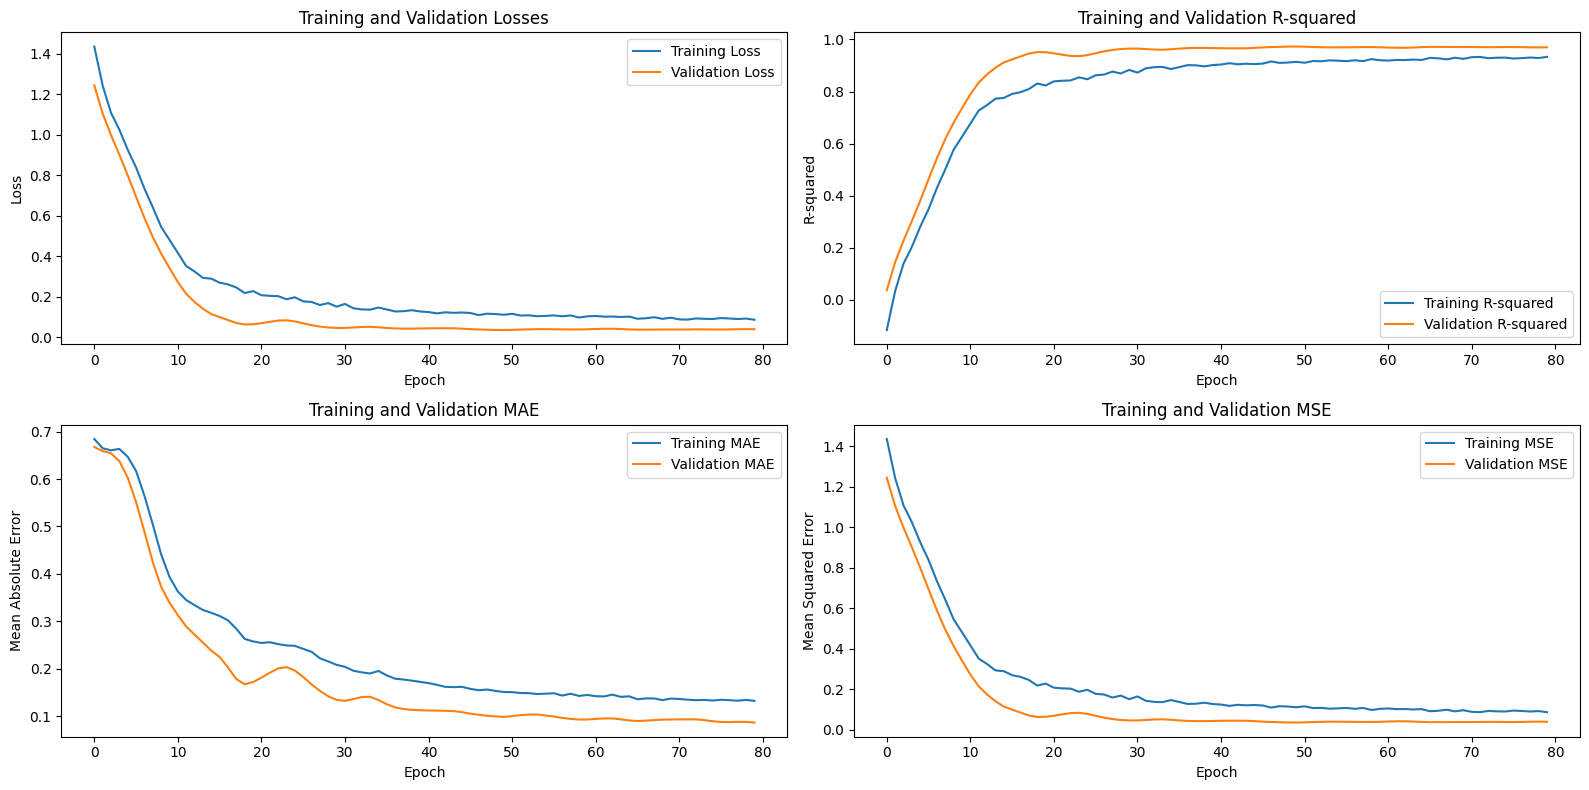

Test R-squared: 0.9783914777179663, Test MAE: 8.63808822631836, Test MSE: 380.6445617675781, Avg Test Residual: 2.352627992630005


In [13]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_LONDON.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_LONDON.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_LONDON.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 0.028288090601563454, Test R-squared: 0.9783914777179663, Test MAE: 8.63808822631836, Test MSE: 380.6445617675781


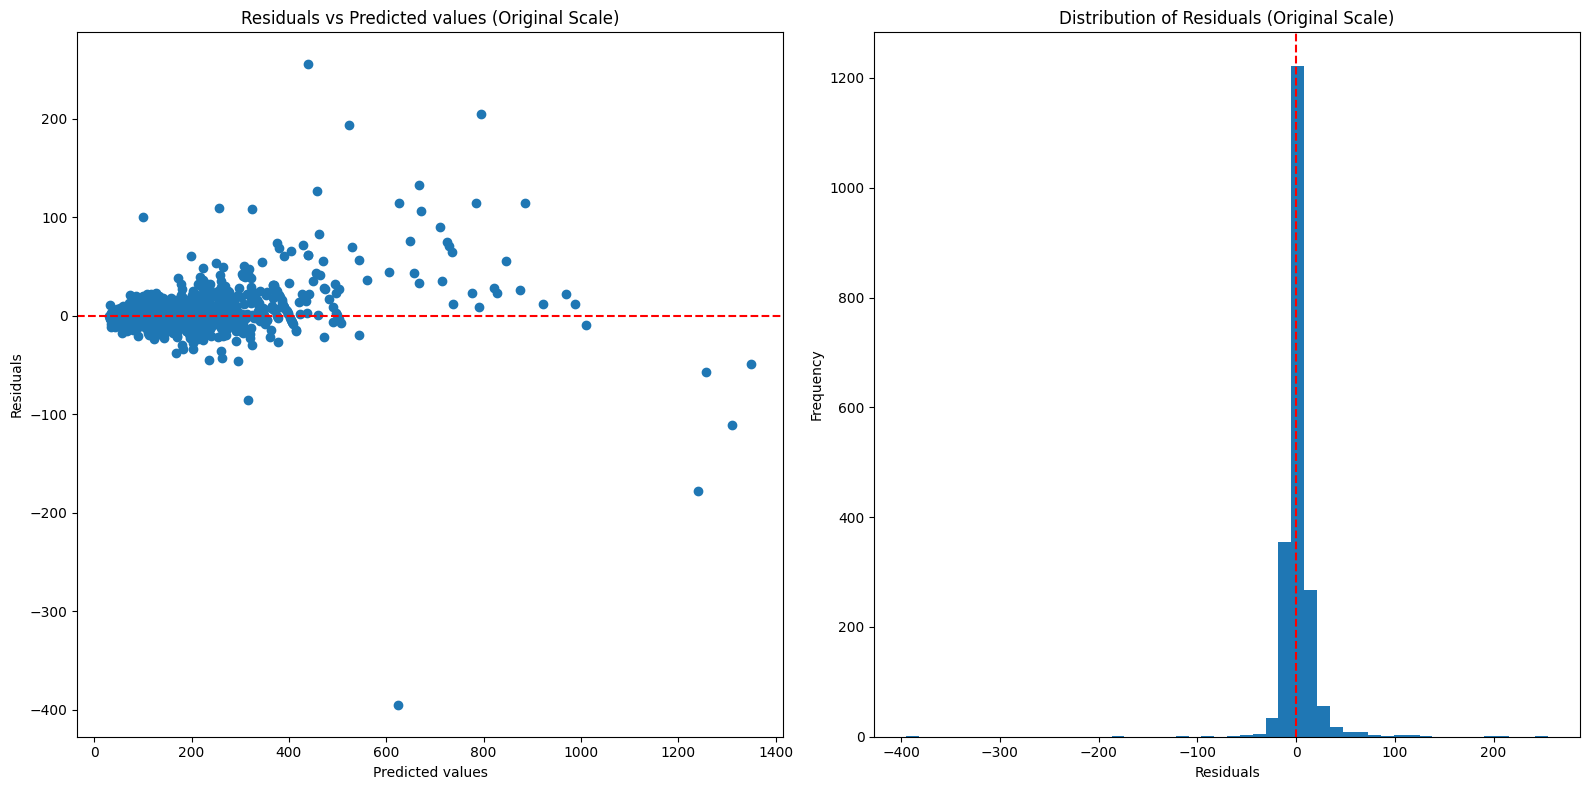

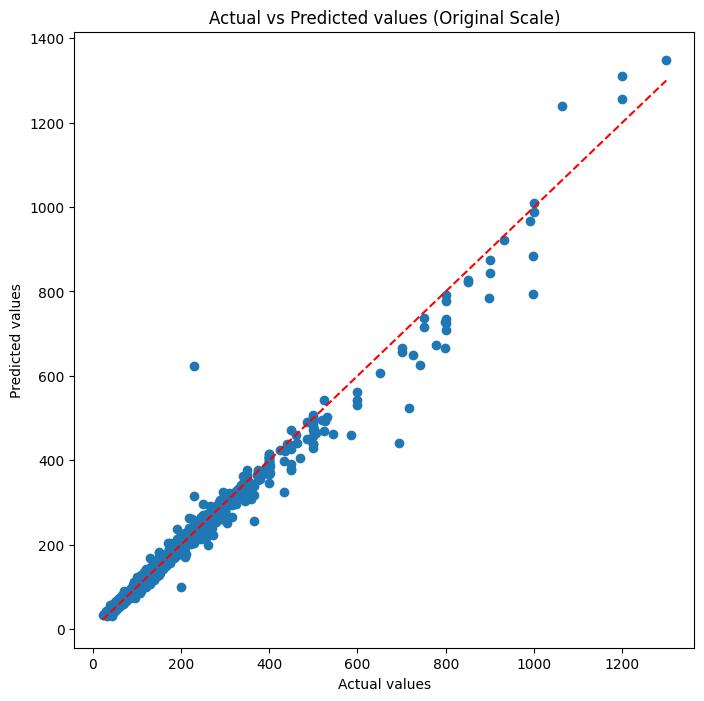

In [14]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

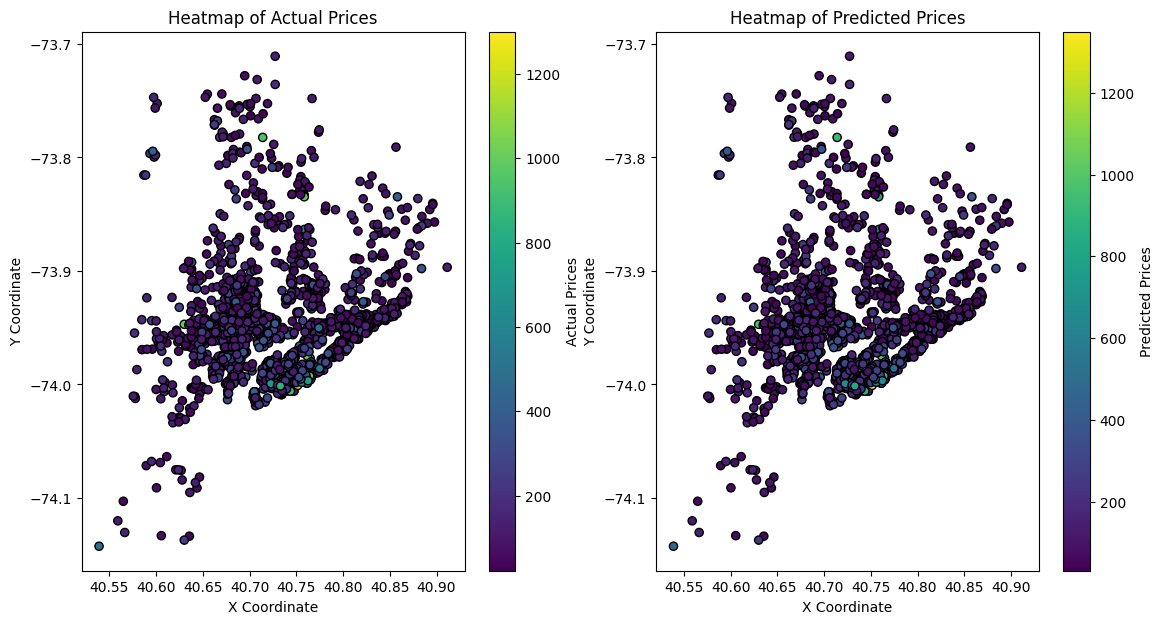

In [15]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


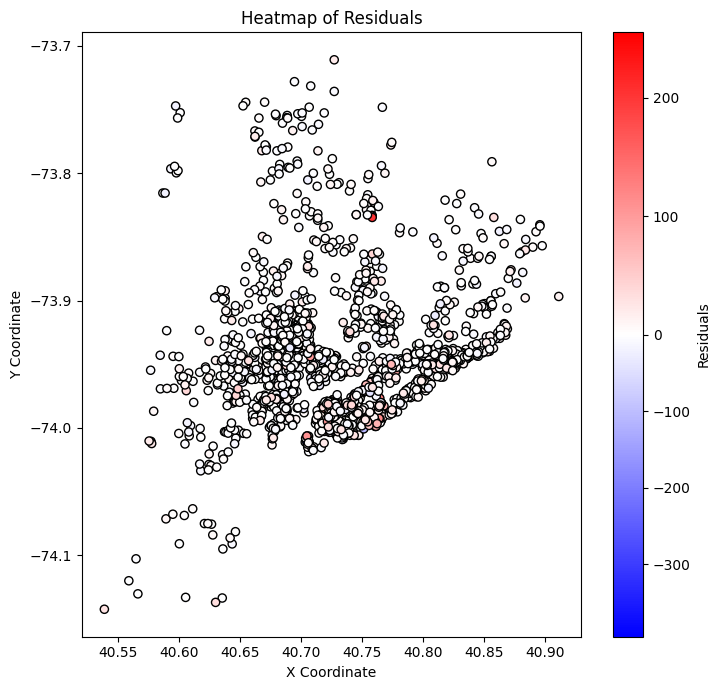

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


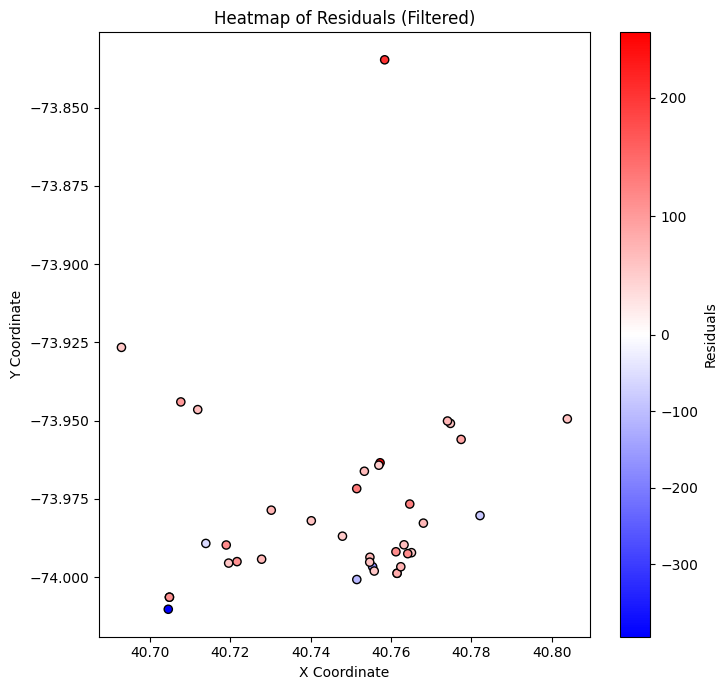

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


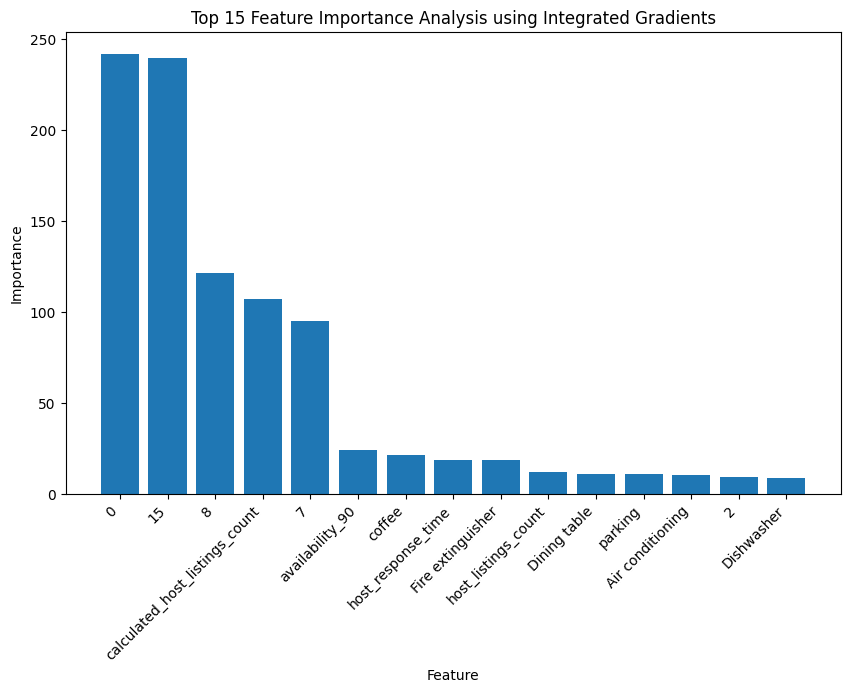

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


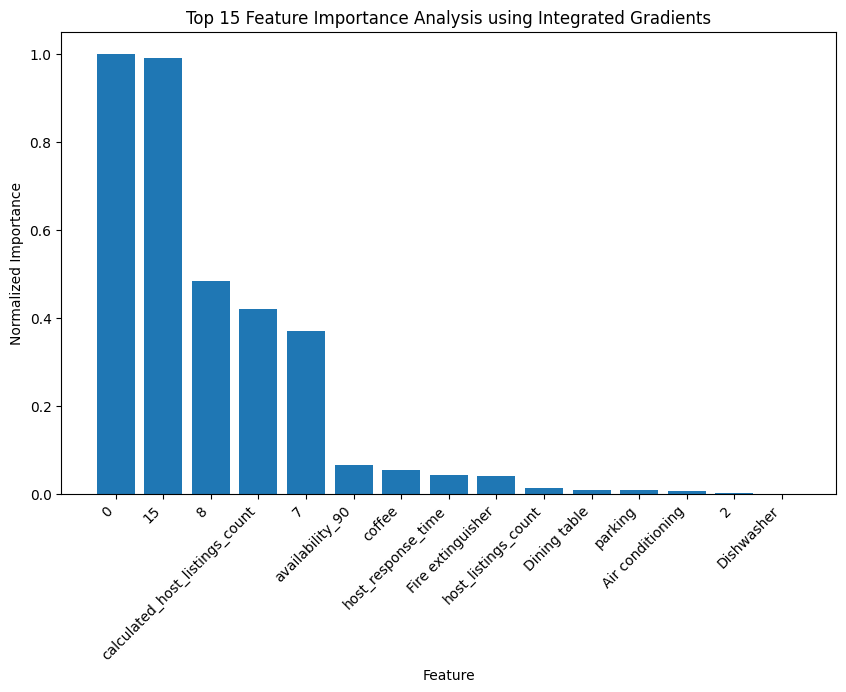

Top 15 Feature Importances (Normalized):
0: 1.0000
15: 0.9891
8: 0.4831
calculated_host_listings_count: 0.4204
7: 0.3687
availability_90: 0.0659
coffee: 0.0536
host_response_time: 0.0415
Fire extinguisher: 0.0405
host_listings_count: 0.0128
Dining table: 0.0088
parking: 0.0084
Air conditioning: 0.0068
2: 0.0016
Dishwasher: 0.0000


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")